In [1]:
import pandas as pd
import pickle
import torch
import numpy as np
from torch_geometric.data import Data, Dataset

We now move onto model training

Below we have the hyperparameters used. I've opted for a small batch size given I have a small dataset and I am betting on a a greater number of small subgroups to best train the model, given the data size limit. I have found that 0.01 is generally the best learning rate. 

In [2]:
hyperparams = {
    'batch_size' : 64, 
    'save_loss_interval' : 10, 
    'print_interval' : 50,
    'n_epochs' : 500, 
    'learning_rate' : 0.025,
    'hidden_size':64, 
    'dropout_rate': 0.3
}

Below we implement a GNN meant for graph-level predicitons. The model performs a binary task as it trys to predict the high/low scoring category for different questions or groups of questions in the annotations questionare. The GNN employs a shallow message passing architecture to account for the inter connected nature of conversation and is enriched through the use of GATs (Graph Attention Networks) to incorporate edge features in classification. 

Ultimatley, the we can either choose a question or a category (task, social, or general cohesion) and accompany our choice by an agreeability parameter (standard deviation for questions or kappa score for categories), and a floor and ceiling metric, such that we restrict our training/testing group to two partions: one below the ceiling and another above the floor, with all data points abiding by the agreeability constraint. 

In [3]:
class CohesionGraphDataset(Dataset):
    def __init__(self, data_list):
        super(CohesionGraphDataset, self).__init__()
        self.data_list = []

        for entry in data_list:
            # Process node features
            node_features_dict = entry['features'][0]
            node_names = list(node_features_dict.keys())  # Example: ['A', 'B', 'C', 'D']
            node_features = []

            # convert features to a tensor
            for node in node_names:
                node_data = node_features_dict[node]
                node_features.append([feature[1] for feature in node_data])  

            x = torch.tensor(node_features, dtype=torch.float)

            # Process edges
            edge_features_dict = entry['features'][1]
            edge_index = []
            edge_attr = []

            # Convert into tensors
            for edge, edge_data in edge_features_dict.items():
                src, dst = edge.split(',')
                src_idx = node_names.index(src)  # Get the node index for source
                dst_idx = node_names.index(dst)  # Get the node index for destination

                # Append the edge index 
                edge_index.append([src_idx, dst_idx])

                # Append the edge attributes (features for this edge)
                edge_attr.append([feature[1] for feature in edge_data])

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  
            edge_attr = torch.tensor(edge_attr, dtype=torch.float) 

            # Store the score as the y label
            y = torch.tensor([entry['score']], dtype=torch.float)

            # Create Geometric Data object
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            self.data_list.append(data)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


Below we have the GNN model. The following features stand out: 

1. Single Convolutional Layer: Convolutional Layers in GNNs are used to derive node embeddings based on a node's surroudning neighbors. The greater the number of layers, the more a node's embeddings are defined by nodes which lie further away. The size and edge density of a graoh should be considered when defining the number of layers, as too many layers for a small and densely connected graph can lead to oversmoothing, a situation where node embedings are homogenous. Given we have a small, fully interconnected graph, we chose a single layer. 

2. Drop Out Layer: Given our sample sizes are rather small, drop out layers are implemented to avoid overfitting

3. GATConv: This mechanism incorporates edge features. I have not taken the time to understand its innerworking, but feel free to: 
https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html

4. Global Mean Pooling: Makes this a graph-level implementation. Chosen rather arbitrarily. 

5. A sigmoid function for binary classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GlobalAttention

NUM_EDGE_FEATURES = 3
NUM_NODE_FEATURES = 12

class CohesionGNN(torch.nn.Module):
    def __init__(self, num_features=NUM_NODE_FEATURES, hidden_size=32, target_size=1, dropout=0.5):
        super(CohesionGNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.dropout = dropout

        # GAT convolution layer
        self.conv1 = GATConv(self.num_features, self.hidden_size, edge_dim=NUM_EDGE_FEATURES)
        
        # Attention mechanism for global graph-level pooling
        self.att = nn.Linear(self.hidden_size, 1)  # To compute attention scores
        
        # Global attention pooling layer
        self.global_att_pool = GlobalAttention(self.att)
        
        # Linear layer for binary classification (output size 1 for binary labels)
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Apply GAT convolution layer
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Graph attention pooling to aggregate node embeddings into graph-level representation
        x = self.global_att_pool(x, batch)  
        
        # Linear layer for final binary prediction
        x = self.linear(x)  
        
        # Apply sigmoid for binary classification (optional, depends on the loss function used)
        x = torch.sigmoid(x)
        
        return x


Below we filter out any nan entries, as they break the model

In [5]:
def filter_out_nan_entries(dataset):
    filtered_data_list = []
    
    for data in dataset:
        if (torch.isnan(data.x).any() or
            torch.isnan(data.edge_attr).any() or
            torch.isnan(data.y).any()):
            continue
        else:
            filtered_data_list.append(data)

    return filtered_data_list

lets read in training sets that are largey artificially generated

In [6]:
# Load the graphs data from file
with open('../graphs/data/graphs_cohesion_data_testing.pkl', 'rb') as f:
    testing = pickle.load(f)
    # Load the graphs data from file
with open('../graphs/data/graphs_cohesion_data_training_base.pkl', 'rb') as f:
    training_base = pickle.load(f)
    # Load the graphs data from file
with open('../graphs/data/graphs_cohesion_data_artificial_gen.pkl', 'rb') as f:
    artificial_graphs = pickle.load(f)

In [7]:
print('Size of testing data: ', len(testing))
print('Size of training_base data: ', len(training_base))
print('Size of artifical data: ', len(artificial_graphs))

Size of testing data:  14
Size of training_base data:  32
Size of artifical data:  919


Size of training/validation set: 951
Size of testing set: 14


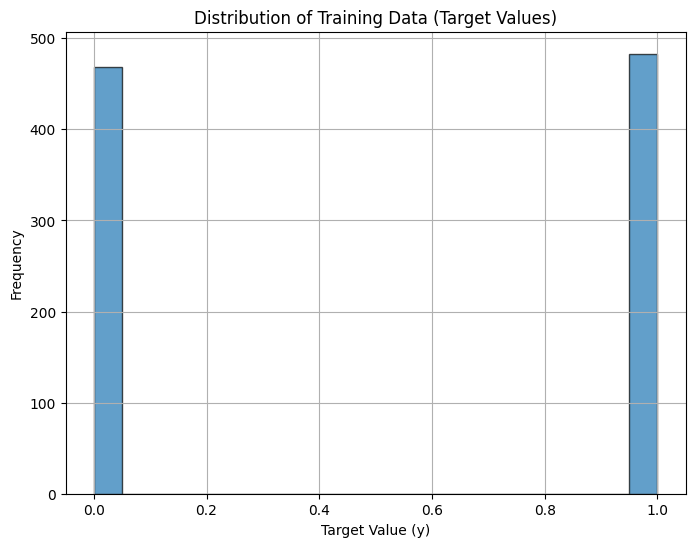

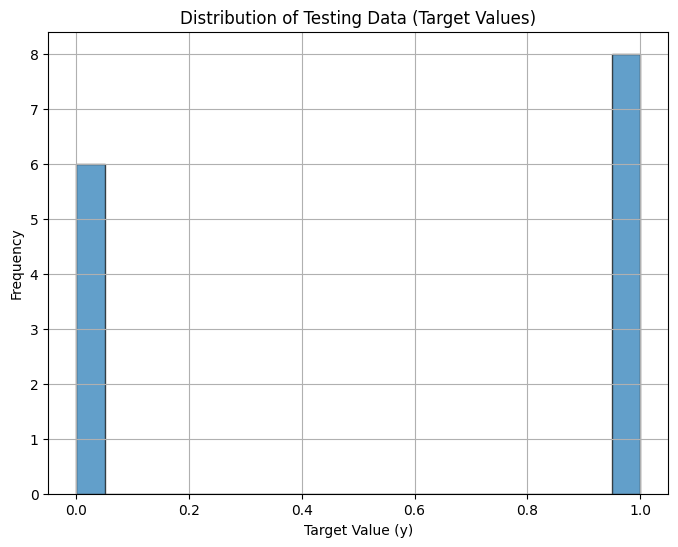

In [8]:
import matplotlib.pyplot as plt

# Combine training_base and artificial_graphs into one list
train_val_combined = training_base + artificial_graphs

# Create the testing dataset
data_test = CohesionGraphDataset(testing)
# Create the training + validation dataset from combined train and artificial data
data_train_val = CohesionGraphDataset(train_val_combined)

# filter out NaN entries in your dataset
data_train_val = filter_out_nan_entries(data_train_val)
data_test = filter_out_nan_entries(data_test)

print(f'Size of training/validation set: {len(data_train_val)}')
print(f'Size of testing set: {len(data_test)}')

# get labels 
train_val_targets = [data.y.item() for data in data_train_val]
test_targets = [data.y.item() for data in data_test]


def plt_suite_dist(data, suite):
    # plot distribution
    # Plot the distribution of the training data (y values)
    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {suite} Data (Target Values)')
    plt.xlabel('Target Value (y)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plt_suite_dist(train_val_targets, 'Training')
plt_suite_dist(test_targets, 'Testing')

For now lets not apply any dense wieghts. But going forward, we ight want to weight loss higher when dealing with annotated samples

In [9]:
from denseweight import DenseWeight

# Lets add a weight to each observation in the training data 
dw = DenseWeight(alpha=0.0)
train_val_weights = dw.fit(train_val_targets)

for i, data in enumerate(data_train_val):
    data.weight = torch.tensor([train_val_weights[i]], dtype=torch.float)

/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


To acount for dataset biases, which predomninantly tend towards high cohesion scores, we will employ the DenseWeight library to obtain weights for each observation which can then be utilized in the loss function to apply a greater penalty to gradients which favor high cohesion predictions. 

In [10]:
import torch.nn.functional as F

def evaluate_model(model, data_loader, device):
    model.eval()  
    total_loss = 0
    with torch.no_grad():  
        for data in data_loader:
            data = data.to(device)
            out = model(data)
            
            loss = F.mse_loss(out.squeeze(-1), data.y)  
            total_loss += loss.item() * data.num_graphs  
    return total_loss / len(data_loader.dataset)  

Customized BCE function to incroporate dense weights and deal with class imbalance. 

In [11]:
import torch
import torch.nn.functional as F

def weighted_bce_loss(pred, target, weight):

    # Apply sigmoid, BCE, and multiply weighted loss (greater loss for laerger predicitons). 
    pred = torch.sigmoid(pred)
    bce_loss = F.binary_cross_entropy(pred, target, reduction='none')
    weighted_loss = weight * bce_loss
    
    return torch.mean(weighted_loss)



Below we train the model using k-fold cross validation. This method is leveraged to compensate for the small training data size. By training k models we randomize the data enough times to better gaugue its generalizability. Additionally, the MSE loss function used is teaked to incorporate weights that accound for sample distribution bias. 

In [12]:
from sklearn.model_selection import KFold
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader  
from torch.utils.data import Subset


# Training loop with k-fold cross-validation
def k_fold_train_model(dataset, k_folds=5, hyperparams=None, patience=15, device='cpu'):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    fold_train_losses = []
    fold_val_losses = []
    
    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"FOLD {fold+1}/{k_folds}")
        print("==========================================")

        # Create training and validation subsets
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        # Data loaders
        train_loader = DataLoader(train_subset, batch_size=hyperparams['batch_size'], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=hyperparams['batch_size'], shuffle=False)
        
        # Initialize model (binary classification with 1 output)
        model = CohesionGNN(num_features=12, hidden_size=hyperparams['hidden_size'], target_size=1, dropout=hyperparams['dropout_rate'])
        model = model.to(device)
        
        # Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
        
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False
        train_losses = []
        val_losses = []

        # Train loop
        for epoch in range(hyperparams['n_epochs']):
            if early_stop:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

            model.train()
            running_loss = 0
            # Training step
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data)
                
                # Use the custom weighted BCE loss
                loss = weighted_bce_loss(out.squeeze(-1), data.y, data.weight)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * data.num_graphs

            avg_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)
            
            # Evaluate on validation set
            val_loss = evaluate_model(model, val_loader, device)
            val_losses.append(val_loss)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), f'models/best_model_fold_{fold+1}.pth') 
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                early_stop = True

            # Print progress
            if epoch % hyperparams['print_interval'] == 0 or early_stop:
                print(f"Epoch: {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Store fold losses
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

        print(f"Fold {fold+1} completed.")
        print("==========================================")
    
    # Average the losses across all folds
    avg_train_loss = [sum(folds) / len(folds) for folds in zip(*fold_train_losses)]
    avg_val_loss = [sum(folds) / len(folds) for folds in zip(*fold_val_losses)]
    
    return avg_train_loss, avg_val_loss


Now we actually train the model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
avg_train_loss, avg_val_loss = k_fold_train_model(data_train_val, 
                                                k_folds=5, 
                                                hyperparams=hyperparams, 
                                                patience=50, 
                                                device='cuda' if torch.cuda.is_available() else 'cpu')

FOLD 1/5


/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch: 0 | Train Loss: 0.6985 | Val Loss: 0.4525
Epoch: 50 | Train Loss: 0.5520 | Val Loss: 0.1083
Epoch: 100 | Train Loss: 0.5452 | Val Loss: 0.0875
Epoch: 117 | Train Loss: 0.5421 | Val Loss: 0.0948
Early stopping triggered after 118 epochs.
Fold 1 completed.
FOLD 2/5
Epoch: 0 | Train Loss: 0.6694 | Val Loss: 0.1223
Epoch: 50 | Train Loss: 0.5534 | Val Loss: 0.1160
Epoch: 100 | Train Loss: 0.5480 | Val Loss: 0.0911
Epoch: 135 | Train Loss: 0.5438 | Val Loss: 0.0764
Early stopping triggered after 136 epochs.
Fold 2 completed.
FOLD 3/5
Epoch: 0 | Train Loss: 0.6971 | Val Loss: 0.4988
Epoch: 50 | Train Loss: 0.5497 | Val Loss: 0.1145
Epoch: 100 | Train Loss: 0.5384 | Val Loss: 0.0708
Epoch: 150 | Train Loss: 0.5275 | Val Loss: 0.0464
Epoch: 188 | Train Loss: 0.5268 | Val Loss: 0.0707
Early stopping triggered after 189 epochs.
Fold 3 completed.
FOLD 4/5
Epoch: 0 | Train Loss: 0.6705 | Val Loss: 0.1469
Epoch: 50 | Train Loss: 0.5481 | Val Loss: 0.1642
Epoch: 63 | Train Loss: 0.5471 | Val 

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_confusion_matrix(all_labels, preds):
    cm = confusion_matrix(all_labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

We will now find the sigmoid threshold at which a split between classes leads to the highest F1 score. 0.5 is found to not be the optimal therhold, presumably because we are dealing with an unblanced dataset. 

In [15]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score

def get_eval(kmodel):
    kmodel.eval()  
    kmodel = kmodel.to(device)

    # Collect predictions and true labels
    all_probs = []
    all_labels = []

    with torch.no_grad():  
        for data in data_test:
            out = kmodel(data).squeeze(-1)  
            probs = torch.sigmoid(out)  
            all_probs.append(probs.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # compute metrics across all test samples
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)

    # Calculate F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Filter out NaN values from F1 scores
    valid_idx = ~np.isnan(f1_scores)
    valid_f1_scores = f1_scores[valid_idx]
    valid_thresholds = thresholds[valid_idx[:-1]]  # thresholds are one element shorter than f1_scores

    # Find the threshold that maximizes the valid F1 score
    optimal_idx = np.argmax(valid_f1_scores)
    optimal_threshold = valid_thresholds[optimal_idx]
    optimal_f1 = valid_f1_scores[optimal_idx]

    print(f"Optimal threshold: {optimal_threshold:.4f}")

    # Evaluate the model using the optimal threshold
    preds = (all_probs >= optimal_threshold).astype(int)

    # Now calculate the final evaluation metrics based on this threshold
    accuracy = accuracy_score(all_labels, preds)
    precision = precision_score(all_labels, preds, zero_division=0)  
    recall = recall_score(all_labels, preds, zero_division=0)  
    f1 = f1_score(all_labels, preds, zero_division=0) 

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Final F1 Score: {f1:.4f}")
    get_confusion_matrix(all_labels, preds)


Test Loss for model 1: 0.1071


/Users/manuelnunezmartinez/Documents/UF/Research Internship/GroupCohesionPrediction/EnvCohesionPrediction/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Optimal threshold: 0.7308
Accuracy: 0.9286
Precision: 0.8889
Recall: 1.0000
Final F1 Score: 0.9412


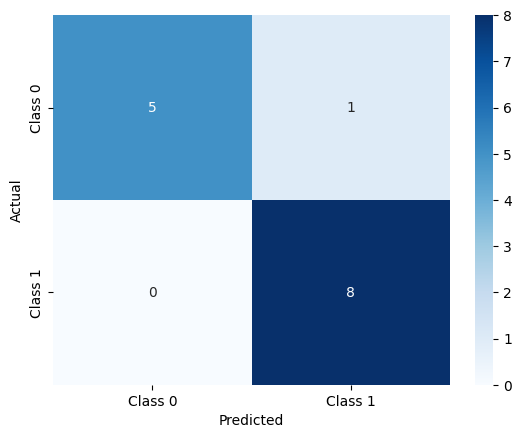

Test Loss for model 2: 0.1429
Optimal threshold: 0.7268
Accuracy: 0.8571
Precision: 0.8000
Recall: 1.0000
Final F1 Score: 0.8889


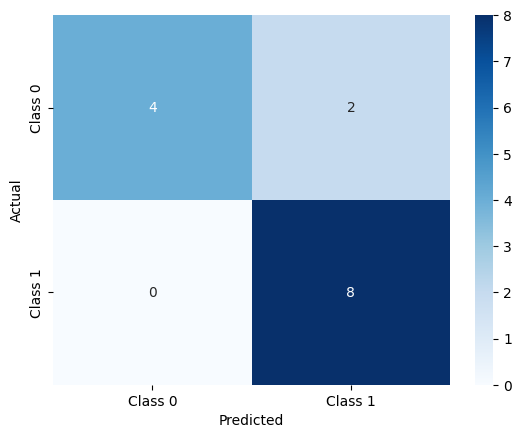

Test Loss for model 3: 0.2857
Optimal threshold: 0.7305
Accuracy: 0.7143
Precision: 0.6667
Recall: 1.0000
Final F1 Score: 0.8000


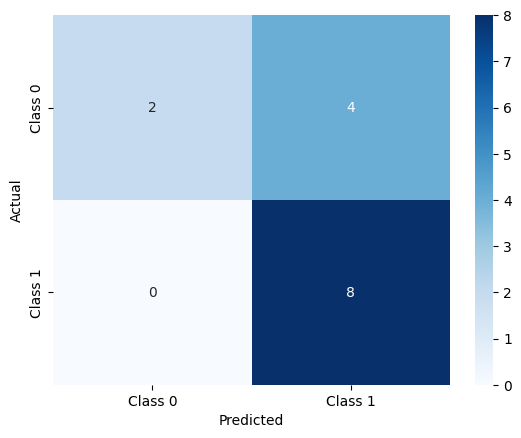

Test Loss for model 4: 0.1417
Optimal threshold: 0.7189
Accuracy: 0.8571
Precision: 0.8000
Recall: 1.0000
Final F1 Score: 0.8889


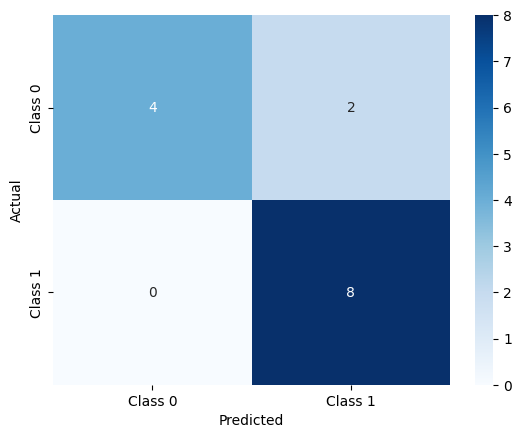

Test Loss for model 5: 0.5757
Optimal threshold: 0.5000
Accuracy: 0.6429
Precision: 0.6154
Recall: 1.0000
Final F1 Score: 0.7619


/var/folders/r_/wwpxjnln7vx4bw2q6dxn_svm0000gn/T/ipykernel_67756/642654200.py:27: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


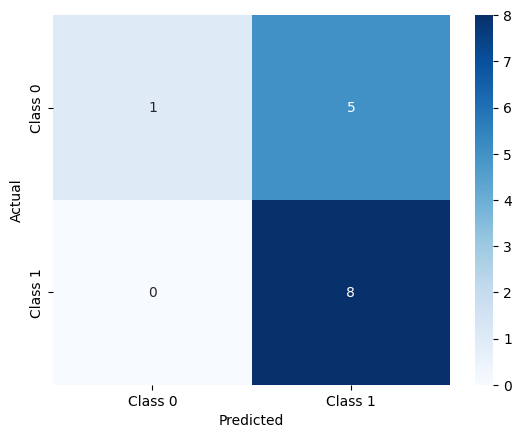

In [16]:
kmodel = CohesionGNN(num_features=12, hidden_size=hyperparams['hidden_size'], target_size=1, dropout=hyperparams['dropout_rate'])
for i in range(5):
    kmodel.load_state_dict(torch.load(f'models/best_model_fold_{i+1}.pth'))

    kmodel.eval()  
    kmodel = kmodel.to(device)

    # Prepare test data loader
    test_loader = DataLoader(data_test, batch_size=hyperparams['batch_size'], shuffle=False)
    test_loss = evaluate_model(kmodel, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Test Loss for model {i + 1}: {test_loss:.4f}")
    get_eval(kmodel)